In [1]:
import sys
sys.path.append("/Users/nrahaman/Python/info-bazaar")
sys.path.append("/Users/nrahaman/Python/speedrun")

In [70]:
import pandas as pd
import seaborn as sns
from pathlib import Path
from itertools import product
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from bazaar.lem_utils import ask_for_guidance, clean_program_string, get_llm, get_closed_book_answer
from bazaar.py_utils import dump_dict

In [11]:
def keep_at_budget(df, budget): 
    return df[df["budget"].round() == budget]


def keep_at_question(df, question): 
    return df[df["question"] == question]

In [19]:
def compare_answers(question, answer_a, answer_b, return_full_answer=False):
    program_str = """
    {{#system~}}
    Michael and Bobby are two machine learning professors grading exams. 
    
    They have a question, and two answers to those questions from two students. In addition, they also have the gold standard answer. Their task is to determine which of the two answers does a better job at answering the question. 
    
    A good answer addresses the question directly with clarity and is easy to understand. It does not go off on tangents, but surfaces information relevant to the question. 
    
    You will simulate a heated debate between Michael and Bobby as they deliberate on this. At the end of the argument, they converge to a fair verdict. The verdict must not be a tie and it must be printed as: 
    
    VERDICT: Better answer from student <A or B>
    {{~/system}}
    
    {{#user~}}
    Question: {{question}}
    
    Answer from student A: {{answer_a}}
    
    Answer from student B: {{answer_b}}
    
    Gold standard answer: {{answer_gold}}
    {{~/user}}
    
    {{#assistant~}}
    {{gen "answer" max_tokens=1024 temperature=0.0}}
    {{~/assistant}}
    """
    program_str = clean_program_string(program_str)
    
    gold_answer = get_closed_book_answer(question, "gpt-4")
    
    program_output = ask_for_guidance(
        program_string=program_str, 
        llm=get_llm(model_name="gpt-4"),
        silent=True,
        inputs=dict(
            question=question,
            answer_a=answer_a,
            answer_b=answer_b,
            answer_gold=gold_answer,
        ),
        output_keys=["answer"],
    )
    
    answer = program_output["answer"]
    
    verdict_lines = [l for l in answer.splitlines() if l.startswith("VERDICT")]
    assert len(verdict_lines) == 1
    verdict_line = verdict_lines[0]
    if verdict_line[-1] in ["A", "B"]: 
        verdict = verdict_line[-1]
    else:
        verdict = verdict_line[-2]
    if return_full_answer:
        return verdict, answer, gold_answer
    else: 
        return verdict

In [30]:
def get_unique_qs(df): 
    return df["question"].unique().tolist()

In [20]:
llama_path = Path("/Users/nrahaman/Downloads/likert_debate_eval_gpt-3.5-turbo_fup-v3-STAR-RemoteLlama-2-70b-chat-hf-STAR.csv")
turbo_path = Path("./raw_data/likert_debate_eval_gpt-3.5-turbo_fup-v3-STAR-gpt-3.5-turbo-STAR.csv")
gpt4_path = Path("./raw_data/likert_debate_eval_gpt-3.5-turbo_fup-STAR-gpt-4-4.605-retrieve.csv")

In [42]:
llama_df = keep_at_budget(pd.read_csv(llama_path), 100)
turbo_df = keep_at_budget(pd.read_csv(turbo_path), 100)
gpt4_df = keep_at_budget(pd.read_csv(gpt4_path), 100)

In [47]:
unique_qs = get_unique_qs(llama_df)

In [50]:
def get_answer_pair_for_question(question, df_a, df_b): 
    df_a = keep_at_question(df_a, question)
    df_b = keep_at_question(df_b, question)
    answer_a, price_a = df_a.iloc[0].answer, df_a.iloc[0].credit_spent
    answer_b, price_b = df_b.iloc[0].answer, df_b.iloc[0].credit_spent
    return (answer_a, price_a), (answer_b, price_b)

In [51]:
def run_matches_between_budget_models(questions, df_a, df_b): 
    verdicts = []
    for question in tqdm(questions):
        (answer_a, price_a), (answer_b, price_b) = get_answer_pair_for_question(
            question, df_a, df_b
        )

        print("*" * 50)
        print("*" * 50)
        print()
        print(question)
        print("-" * 50)
        print(f"Answer A (${price_a:.2f}):")
        print(answer_a)
        print("-" * 50)
        print(f"Answer B (${price_b:.2f}):")
        print(answer_b)

        print("=" * 50)
        print()

        verdict, debate, gold_answer = compare_answers(question, answer_a, answer_b, True)

        print("-" * 50)
        print("Gold answer:")
        print(gold_answer)

        print("-" * 50)
        print("Debate:")
        print(debate)

        verdicts.append(
            dict(
                question=question, 
                debate=debate, 
                gold_answer=gold_answer,
                verdict=verdict,
                answer_a=answer_a,
                answer_b=answer_b, 
                price_a=price_a, 
                price_b=price_b,
            )
        )

        print()
        print("*" * 50)
        print("*" * 50)
        print()
    return verdicts


In [52]:
unique_qs[0]

'What is the name of the architecture that has dominated natural language processing (NLP) benchmarks in recent years?'

In [54]:
verdicts_llama_turbo = run_matches_between_budget_models(unique_qs, llama_df, turbo_df)

  0%|                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

**************************************************
**************************************************

What is the name of the architecture that has dominated natural language processing (NLP) benchmarks in recent years?
--------------------------------------------------
Answer A ($105.54):
The architecture that has dominated natural language processing (NLP) benchmarks in recent years is the Generative Pre-trained Transformer (GPT) series models, including ChatGPT, due to their ability to generate instructions and follow them, unique architecture, and training, few-shot learning, and adaptability to new tasks, and fine-tuning. These features have allowed GPT models to adapt to various NLP tasks, such as challenging math problems or symbolic manipulation problems, NLP classification tasks, speech and vision tasks, and other tasks that benefit from the use of large language models. GPT models have shown particular strengths in tasks that require an understanding of human language and th

 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:31<04:39, 15.52s/it]

--------------------------------------------------
Gold answer:
As an AI, I don't have real-time data or the ability to access up-to-date information. As of my last update, I don't have specific data on how many days after its release ChatGPT attracted over a million users. For the most accurate information, please refer to the latest reports or OpenAI's official announcements.
--------------------------------------------------
Debate:
Michael: I think student A's answer is better. It provides a specific timeframe, even if it's not exact.

Bobby: But Michael, the question asks for the number of days. Student A's answer is vague, saying "within days or weeks". That's not a specific answer.

Michael: I agree, Bobby, but student B's answer doesn't provide any information at all. It just says the exact number of days is unknown.

Bobby: That's true, but at least student B is honest about not knowing the answer. Student A is just guessing and could be misleading.

Michael: But Bobby, we're 

 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [01:07<06:48, 24.05s/it]

--------------------------------------------------
Gold answer:
InstructGPT, developed by OpenAI, is trained using a two-step process: pre-training and fine-tuning. Reinforcement Learning from Human Feedback (RLHF) is used in the fine-tuning stage.

In the fine-tuning process, reinforcement learning is used to refine the model's responses based on feedback from human AI trainers. These trainers provide rankings for different model-generated responses, creating a reward model. The model is then fine-tuned using Proximal Policy Optimization, a reinforcement learning algorithm, to generate responses that are more likely to receive higher rankings.

This process is iterative, with multiple rounds of reinforcement learning to continually improve the model's performance. However, it's important to note that reinforcement learning is not used in the initial pre-training stage, where the model learns to predict the next word in a sentence using a large dataset of internet text.
---------------

 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [01:38<07:12, 27.00s/it]

--------------------------------------------------
Gold answer:
As an AI, I don't have real-time capabilities or future prediction abilities. As of the last update, there is no specific significance to the date November 30th, 2022, in the development of language models. However, the field of AI and language models is rapidly evolving, so significant developments could occur at any time.
--------------------------------------------------
Debate:
Michael: I think student A's answer is better. They not only addressed the question directly but also provided additional context by mentioning that the provided passages do not contain any relevant information.

Bobby: I disagree, Michael. Student B's answer is more concise and to the point. They directly addressed the question without adding unnecessary information.

Michael: But Bobby, the additional information in student A's answer isn't unnecessary. It provides context and shows that the student has thoroughly examined the provided materia

 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [02:17<07:43, 30.90s/it]

--------------------------------------------------
Gold answer:
Continuous prompts and discrete prompts are terms often used in the field of machine learning, particularly in reinforcement learning.

Continuous prompts refer to a type of input or action space where the possible values are in a continuous range. For example, adjusting the temperature of a thermostat can be a continuous prompt, as the temperature can be set to any value within a certain range, like 18.5 degrees or 22.7 degrees.

On the other hand, discrete prompts refer to a type of input or action space where the possible values are distinct and separate. For example, choosing a channel on a television can be a discrete prompt, as you can only choose from a set number of channels, like channel 1, channel 2, channel 3, etc.

In the context of AI training, continuous prompts might require more complex algorithms to handle the infinite possibilities, while discrete prompts can be easier to manage due to their limited and d

 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [03:01<08:15, 35.40s/it]

--------------------------------------------------
Gold answer:
In-context learning can occur even when there's a distribution mismatch between prompts and pretraining data. However, the effectiveness of the learning might be impacted. The AI model might struggle to generalize or make accurate predictions if the prompts it's receiving during fine-tuning are significantly different from the data it was pretrained on. This is because the model learns patterns and structures from the pretraining data, and applies this knowledge to the prompts it receives later. If there's a large mismatch, the model might not have learned the necessary patterns to handle the new prompts effectively.
--------------------------------------------------
Debate:
Michael: I think student A's answer is better. It's more detailed and provides a comprehensive understanding of in-context learning. It also addresses the question directly and provides additional information on how to improve the performance of in-con

 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [03:48<08:26, 38.96s/it]

--------------------------------------------------
Gold answer:
I'm sorry, but as of my current knowledge update, I don't have specific information about LLaMA-Adapter and LLaMA-Adapter-V2. These could be specific software, tools, or modules within a certain field, but without more context, it's difficult to provide an accurate answer. It's also possible that these are very new or niche tools that haven't been widely documented yet. I would recommend checking the official documentation or reaching out to the creators for the most accurate information.
--------------------------------------------------
Debate:
Michael: I think student A's answer is better. It provides a more detailed explanation of the difference between LLaMA-Adapter and LLaMA-Adapter-V2. It also mentions the efficiency of LLaMA-Adapter and its ability to generate high-quality responses, which is relevant to the question.

Bobby: I disagree, Michael. While student A's answer is indeed more detailed, it introduces infor

 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [04:23<07:33, 37.75s/it]

--------------------------------------------------
Gold answer:
BERT (Bidirectional Encoder Representations from Transformers) and GPT (Generative Pretrained Transformer) are both transformer-based models used in natural language processing, but they have different approaches and uses.

1. Directionality: BERT is bidirectional, meaning it looks at the context from both the left and the right side of a word during training. This allows it to understand the context better. On the other hand, GPT is unidirectional (specifically, left-to-right), meaning it only considers the context to the left of the word during training.

2. Training Objective: BERT is trained to predict masked words in a sentence (a task known as masked language modeling), which helps it understand the context of words. GPT, on the other hand, is trained to predict the next word in a sentence (a task known as causal language modeling or autoregressive language modeling).

3. Use Cases: BERT is often used for tasks that 

 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [05:02<07:01, 38.29s/it]

--------------------------------------------------
Gold answer:
As an AI, I don't have real-time data or updates. However, as of my last update, there is a growing body of research comparing the performances of different language models on benchmarks that measure toxic language harms. The results can vary significantly depending on the specific language model and the benchmark used.

For instance, some studies have found that larger language models like GPT-3 can sometimes generate harmful or toxic outputs, even when they're not explicitly prompted to do so. Other models, like BERT, have been found to sometimes struggle with understanding the context of potentially harmful language, which can lead to false positives or negatives.

However, it's important to note that these models are continually being updated and improved. Many AI developers are working on ways to reduce the potential for harmful or toxic language generation, such as by implementing better moderation tools or by traini

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [05:39<06:17, 37.77s/it]

--------------------------------------------------
Gold answer:
The approach you're referring to is known as "Cooperative Source-Target Training" or "CoST". It's a method where the model generates rationales which are then used to fine-tune the model itself, creating a feedback loop that improves the model's reasoning capabilities.
--------------------------------------------------
Debate:
Michael: Well, this seems pretty straightforward to me. Student A's answer is the only one that actually provides an answer. Student B's response didn't parse at all.

Bobby: Yes, but we're not just looking for an answer, we're looking for the correct answer. Student A's answer, while detailed, is incorrect. They mentioned "self-supervised learning" and "self-guided reasoning", but the gold standard answer is "Cooperative Source-Target Training" or "CoST".

Michael: That's true, but at least Student A made an attempt to answer the question. Student B didn't provide any answer at all. 

Bobby: I agree

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [06:24<06:00, 40.02s/it]

--------------------------------------------------
Gold answer:
Large Language Models (LLMs) like GPT-3 are trained on vast amounts of text data from the internet. Biases and fairness issues can arise in these models because they learn from the data they are trained on, which can include biased language, stereotypes, and discriminatory content. This can lead to the model generating biased or unfair outputs.

There are several ways to mitigate these issues:

1. Diverse Training Data: Ensuring the training data is diverse and representative of different perspectives can help reduce bias. This includes data from different cultures, genders, races, and socio-economic backgrounds.

2. De-biasing Techniques: These techniques aim to reduce the bias in the model's outputs. For example, some techniques modify the training data to reduce the presence of biased language, while others adjust the model's parameters after training to minimize bias.

3. Transparency and Interpretability: Making the m

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [07:02<05:16, 39.51s/it]

--------------------------------------------------
Gold answer:
Model selection in machine learning serves several important purposes:

1. Choosing the Best Model: The primary purpose of model selection is to choose the most suitable model that can perform well on unseen data. This involves comparing different machine learning algorithms and selecting the one that best fits the data.

2. Avoiding Overfitting and Underfitting: Model selection helps in avoiding overfitting (where the model performs well on training data but poorly on unseen data) and underfitting (where the model performs poorly on both training and unseen data). 

3. Optimizing Hyperparameters: Model selection also involves tuning the hyperparameters of a model to improve its performance. Hyperparameters are the parameters of the learning algorithm itself, which are not learned from the data.

4. Simplifying Complexity: Sometimes simpler models can perform as well as complex ones. Model selection can help in choosing th

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [07:25<04:02, 34.57s/it]

--------------------------------------------------
Gold answer:
Cross-validation in machine learning is a technique used to assess the performance of a machine learning model on an independent data set, and to tune the parameters of the model. The main purpose of cross-validation is to prevent overfitting, which occurs when a model learns the training data too well and performs poorly on unseen data.

In cross-validation, the data set is divided into two segments: one used to train the model and the other used to validate the model. During the cross-validation process, the training and validation sets can be rotated and reused to maximize the amount of data used.

This process provides a more accurate measure of how well the model will perform on unseen data and helps in selecting the most suitable model by comparing the performance of different models.
--------------------------------------------------
Debate:
Michael: Well, this one seems pretty straightforward to me. Student A has p

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [08:02<03:31, 35.28s/it]

--------------------------------------------------
Gold answer:
Reinforcement Learning (RL) is a type of machine learning where an agent learns to make decisions by taking actions in an environment to achieve a goal. The agent is rewarded or penalized (with points, for example) for the actions it takes, learning over time to maximize its rewards and minimize its penalties. This is done through trial and error, with the agent continuously refining its strategy with each action it takes. Reinforcement learning is particularly useful in situations where the agent has no prior knowledge and must learn to perform a task solely from feedback.
--------------------------------------------------
Debate:
Michael: I think student A's answer is better. It's more detailed and provides examples of where reinforcement learning can be applied.

Bobby: I disagree, Michael. While student A's answer is indeed more detailed, it's not necessarily better. Student B's answer is more concise and to the point,

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [08:39<02:58, 35.77s/it]

--------------------------------------------------
Gold answer:
Pre-training in Language Model Learning (LLMs) serves several important purposes:

1. Learning General Language Understanding: Pre-training helps the model to learn the general aspects of the language, such as grammar, syntax, semantics, and some level of world knowledge. This is achieved by training the model on a large corpus of text.

2. Transfer Learning: The knowledge gained from pre-training can be transferred to various specific tasks with fine-tuning, which often requires less data. This is particularly useful when the task-specific data is limited.

3. Improved Performance: Pre-training often leads to better performance on downstream tasks. It provides a good initialization point for the model parameters, which can lead to faster convergence and better overall performance.

4. Efficiency: Pre-training can also make the training process more efficient. Instead of training a model from scratch for each specific task

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [09:25<02:34, 38.63s/it]

--------------------------------------------------
Gold answer:
In the context of LLMs (Lifelong Machine Learning), the primary focus of work on scaling laws is to understand how the performance of machine learning models improves as the amount of data or computational resources increases. Scaling laws can help to predict the efficiency and effectiveness of machine learning algorithms as they are exposed to more data or given more computational power. This is particularly important in LLMs, where the system is expected to learn continuously from a stream of data over its entire lifetime. The goal is to develop models that can scale effectively and efficiently, improving their performance over time without requiring excessive resources.
--------------------------------------------------
Debate:
Michael: I think student A's answer is more comprehensive. They've touched on the trade-offs between model size, computational resources, and performance, which is a crucial aspect of scaling law

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [09:55<01:48, 36.08s/it]

--------------------------------------------------
Gold answer:
1. Data Quality: Ensure that the data used for training is of high quality, diverse, and representative of the problem space. This helps to avoid biases and overfitting.

2. Cross-Validation: Use cross-validation techniques to assess how the results of the model will generalize to an independent data set. This helps to prevent overfitting.

3. Regularization: Apply regularization methods to prevent overfitting. This includes techniques like L1 and L2 regularization.

4. Ensemble Methods: Use ensemble methods like bagging and boosting to improve the stability and accuracy of machine learning models.

5. Hyperparameter Tuning: Perform hyperparameter tuning to optimize the parameters of the model and improve its performance.

6. Feature Selection: Use feature selection techniques to identify and select important features, reducing overfitting and improving model interpretability.

7. Model Evaluation: Evaluate the model using

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [10:31<01:12, 36.17s/it]

--------------------------------------------------
Gold answer:
"Emergent capabilities" in the context of large language models refer to the abilities or features that were not explicitly programmed into the model, but rather developed as a result of the model's learning process. These capabilities can include understanding complex language structures, generating creative text, answering questions accurately, and even demonstrating a basic understanding of certain topics. These capabilities emerge from the model's exposure to vast amounts of data and its ability to identify patterns and relationships within that data.
--------------------------------------------------
Debate:
Michael: I think student A's answer is better. It's more detailed and provides examples of how these emergent capabilities can be applied in various industries and domains. It also mentions techniques for acquiring external knowledge, which is a crucial aspect of emergent capabilities.

Bobby: I see your point, Mi

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [11:22<00:40, 40.57s/it]

--------------------------------------------------
Gold answer:
LLMs, or Large Language Models, are powerful tools that can generate human-like text based on the input they receive. However, using them in high-stakes applications without proper interpretability can lead to several potential consequences:

1. Misinformation: If the LLM is not properly trained or interpreted, it could generate incorrect or misleading information. This could have serious consequences in high-stakes applications like healthcare, finance, or legal advice.

2. Bias: LLMs learn from the data they are trained on. If this data contains biases, the LLM can perpetuate and even amplify these biases. This could lead to unfair or discriminatory outcomes.

3. Lack of Transparency: Without proper interpretability, it can be difficult to understand why an LLM is making certain decisions or predictions. This lack of transparency can make it hard to trust the LLM's outputs, especially in high-stakes situations.

4. Legal

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [12:04<00:00, 36.23s/it]

--------------------------------------------------
Gold answer:
Large language models and neurosymbolic reasoning are both approaches to artificial intelligence, but they operate differently and can complement each other.

Large language models, like GPT-3, are based on machine learning techniques, specifically deep learning. They are trained on vast amounts of text data and learn to generate human-like text by predicting the next word in a sequence. They excel at tasks that involve pattern recognition and generalization from examples.

Neurosymbolic reasoning, on the other hand, combines neural networks with symbolic reasoning. Symbolic reasoning is a traditional AI approach that uses explicit symbols and rules to represent and manipulate knowledge. It is good at tasks that require logical reasoning, understanding of complex relationships, and handling of explicit rules and constraints.

While large language models are good at learning from data and generating text, they often lack th

In [55]:
# _ = dump_dict(verdicts_llama_turbo, "./assets/verdicts_gpt4_llama-v-turbo.json")

In [56]:
verdicts_llama_gpt4 = run_matches_between_budget_models(unique_qs, llama_df, gpt4_df)

  0%|                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

**************************************************
**************************************************

What is the name of the architecture that has dominated natural language processing (NLP) benchmarks in recent years?
--------------------------------------------------
Answer A ($105.54):
The architecture that has dominated natural language processing (NLP) benchmarks in recent years is the Generative Pre-trained Transformer (GPT) series models, including ChatGPT, due to their ability to generate instructions and follow them, unique architecture, and training, few-shot learning, and adaptability to new tasks, and fine-tuning. These features have allowed GPT models to adapt to various NLP tasks, such as challenging math problems or symbolic manipulation problems, NLP classification tasks, speech and vision tasks, and other tasks that benefit from the use of large language models. GPT models have shown particular strengths in tasks that require an understanding of human language and th

  5%|██████████                                                                                                                                                                                                | 1/20 [00:28<08:53, 28.10s/it]

--------------------------------------------------
Gold answer:
The architecture that has dominated natural language processing (NLP) benchmarks in recent years is called Transformer architecture. Models based on this architecture, such as BERT (Bidirectional Encoder Representations from Transformers), GPT-3 (Generative Pretrained Transformer 3), and T5 (Text-to-Text Transfer Transformer), have achieved state-of-the-art results on various NLP tasks.
--------------------------------------------------
Debate:
Michael: I think student A's answer is better. It's more detailed and provides a lot of information about the GPT series models and their capabilities.

Bobby: I disagree, Michael. The question asks for the name of the architecture, not a detailed explanation of a specific model. Student B's answer is more direct and to the point. It correctly identifies the Transformer architecture as the one that has dominated NLP benchmarks.

Michael: But don't you think that the additional infor

 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:55<08:23, 27.98s/it]

--------------------------------------------------
Gold answer:
As an AI, I don't have real-time data or the ability to access up-to-date information. As of my last update, I don't have specific data on how many days after its release ChatGPT attracted over a million users. For the most accurate information, please refer to the latest reports or OpenAI's official announcements.
--------------------------------------------------
Debate:
Michael: Well, this seems pretty straightforward to me. Student A at least attempted to answer the question, while student B didn't provide any answer at all.

Bobby: I agree that student B didn't provide an answer, but we can't just ignore the fact that student A's answer is not accurate. The gold standard answer clearly states that there's no specific data available on this.

Michael: Yes, but the question was about how many days after its release did ChatGPT attract over a million users. Student A's answer, although not precise, does give a general ti

 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [01:36<09:29, 33.49s/it]

--------------------------------------------------
Gold answer:
InstructGPT, developed by OpenAI, is trained using a two-step process: pre-training and fine-tuning. Reinforcement Learning from Human Feedback (RLHF) is used in the fine-tuning stage.

In the fine-tuning process, reinforcement learning is used to refine the model's responses based on feedback from human AI trainers. These trainers provide rankings for different model-generated responses, creating a reward model. The model is then fine-tuned using Proximal Policy Optimization, a reinforcement learning algorithm, to generate responses that are more likely to receive higher rankings.

This process is iterative, with multiple rounds of reinforcement learning to continually improve the model's performance. However, it's important to note that reinforcement learning is not used in the initial pre-training stage, where the model learns to predict the next word in a sentence using a large dataset of internet text.
---------------

 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [02:12<09:15, 34.69s/it]

--------------------------------------------------
Gold answer:
As an AI, I don't have real-time capabilities or future prediction abilities. As of the last update, there is no specific significance to the date November 30th, 2022, in the development of language models. However, the field of AI and language models is rapidly evolving, so significant developments could occur at any time.
--------------------------------------------------
Debate:
Michael: I think student B's answer is better. They mentioned the release of a language model, ChatGPT, which is relevant to the question.

Bobby: But Michael, the question is about the significance of the date November 30th, 2022. Student B's answer is incorrect because as per the gold standard answer, there is no specific significance to this date in the development of language models.

Michael: Yes, but at least student B tried to provide a relevant event related to language models. Student A's answer is just a denial without any attempt to p

 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [03:02<10:04, 40.32s/it]

--------------------------------------------------
Gold answer:
Continuous prompts and discrete prompts are terms often used in the field of machine learning, particularly in reinforcement learning.

Continuous prompts refer to a type of input or action space where the possible values are in a continuous range. For example, adjusting the temperature of a thermostat can be a continuous prompt, as the temperature can be set to any value within a certain range, like 18.5 degrees or 22.7 degrees.

On the other hand, discrete prompts refer to a type of input or action space where the possible values are distinct and separate. For example, choosing a channel on a television can be a discrete prompt, as you can only choose from a set number of channels, like channel 1, channel 2, channel 3, etc.

In the context of AI training, continuous prompts might require more complex algorithms to handle the infinite possibilities, while discrete prompts can be easier to manage due to their limited and d

 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [03:49<09:55, 42.55s/it]

--------------------------------------------------
Gold answer:
In-context learning can occur even when there's a distribution mismatch between prompts and pretraining data. However, the effectiveness of the learning might be impacted. The AI model might struggle to generalize or make accurate predictions if the prompts it's receiving during fine-tuning are significantly different from the data it was pretrained on. This is because the model learns patterns and structures from the pretraining data, and applies this knowledge to the prompts it receives later. If there's a large mismatch, the model might not have learned the necessary patterns to handle the new prompts effectively.
--------------------------------------------------
Debate:
Michael: I think student A's answer is better. It's more detailed and provides a comprehensive understanding of in-context learning. The student also mentions various techniques that can be used to improve the performance of in-context learning when th

 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [04:34<09:22, 43.29s/it]

--------------------------------------------------
Gold answer:
I'm sorry, but as of my current knowledge update, I don't have specific information about LLaMA-Adapter and LLaMA-Adapter-V2. These could be specific software, tools, or modules within a certain field, but without more context, it's difficult to provide an accurate answer. It's also possible that these are very new or niche tools that haven't been widely documented yet. I would recommend checking the official documentation or reaching out to the creators for the most accurate information.
--------------------------------------------------
Debate:
Michael: I think student A's answer is better. It's concise and directly addresses the question. It provides a clear difference between LLaMA-Adapter and LLaMA-Adapter-V2, and even gives a comparison to another model, Alpaca.

Bobby: I disagree, Michael. Student B's answer, while a bit lengthy, provides a more comprehensive understanding of both LLaMA-Adapter and LLaMA-Adapter-V2.

 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [05:08<08:02, 40.19s/it]

--------------------------------------------------
Gold answer:
BERT (Bidirectional Encoder Representations from Transformers) and GPT (Generative Pretrained Transformer) are both transformer-based models used in natural language processing, but they have different approaches and uses.

1. Directionality: BERT is bidirectional, meaning it looks at the context from both the left and the right side of a word during training. This allows it to understand the context better. On the other hand, GPT is unidirectional (specifically, left-to-right), meaning it only considers the context to the left of the word during training.

2. Training Objective: BERT is trained to predict masked words in a sentence (a task known as masked language modeling), which helps it understand the context of words. GPT, on the other hand, is trained to predict the next word in a sentence (a task known as causal language modeling or autoregressive language modeling).

3. Use Cases: BERT is often used for tasks that 

 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [05:52<07:36, 41.53s/it]

--------------------------------------------------
Gold answer:
As an AI, I don't have real-time data or updates. However, as of my last update, there is a growing body of research comparing the performances of different language models on benchmarks that measure toxic language harms. The results can vary significantly depending on the specific language model and the benchmark used.

For instance, some studies have found that larger language models like GPT-3 can sometimes generate harmful or toxic outputs, even when they're not explicitly prompted to do so. Other models, like BERT, have been found to sometimes struggle with understanding the context of potentially harmful language, which can lead to false positives or negatives.

However, it's important to note that these models are continually being updated and improved. Many AI developers are working on ways to reduce the potential for harmful or toxic language generation, such as by implementing better moderation tools or by traini

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [06:25<06:27, 38.77s/it]

--------------------------------------------------
Gold answer:
The approach you're referring to is known as "Cooperative Source-Target Training" or "CoST". It's a method where the model generates rationales which are then used to fine-tune the model itself, creating a feedback loop that improves the model's reasoning capabilities.
--------------------------------------------------
Debate:
Michael: Well, this is a no-brainer. Student A's answer is the only one that actually provides an answer. Student B's response is just "nan", which is not an answer at all.

Bobby: Yes, I agree that student B's answer is not acceptable. However, student A's answer, while it does provide an answer, it's not the correct one. The question is asking about "Cooperative Source-Target Training" or "CoST", not "self-supervised learning" or "self-guided reasoning".

Michael: That's true, but at least student A made an attempt to answer the question. They provided a detailed response and even gave examples of 

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [07:13<06:15, 41.73s/it]

--------------------------------------------------
Gold answer:
Large Language Models (LLMs) like GPT-3 are trained on vast amounts of text data from the internet. Biases and fairness issues can arise in these models because they learn from the data they are trained on, which can include biased language, stereotypes, and discriminatory content. This can lead to the model generating biased or unfair outputs.

There are several ways to mitigate these issues:

1. Diverse Training Data: Ensuring the training data is diverse and representative of different perspectives can help reduce bias. This includes data from different cultures, genders, races, and socio-economic backgrounds.

2. De-biasing Techniques: These techniques aim to reduce the bias in the model's outputs. For example, some techniques modify the training data to reduce the presence of biased language, while others adjust the model's parameters after training to minimize bias.

3. Transparency and Interpretability: Making the m

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [07:58<05:42, 42.77s/it]

--------------------------------------------------
Gold answer:
Model selection in machine learning serves several important purposes:

1. Choosing the Best Model: The primary purpose of model selection is to choose the most suitable model that can perform well on unseen data. This involves comparing different machine learning algorithms and selecting the one that best fits the data.

2. Avoiding Overfitting and Underfitting: Model selection helps in avoiding overfitting (where the model performs well on training data but poorly on unseen data) and underfitting (where the model performs poorly on both training and unseen data). 

3. Optimizing Hyperparameters: Model selection also involves tuning the hyperparameters of a model to improve its performance. Hyperparameters are the parameters of the learning algorithm itself, which are not learned from the data.

4. Simplifying Complexity: Sometimes simpler models can perform as well as complex ones. Model selection can help in choosing th

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [08:29<04:34, 39.23s/it]

--------------------------------------------------
Gold answer:
Cross-validation in machine learning is a technique used to assess the performance of a machine learning model on an independent data set, and to tune the parameters of the model. The main purpose of cross-validation is to prevent overfitting, which occurs when a model learns the training data too well and performs poorly on unseen data.

In cross-validation, the data set is divided into two segments: one used to train the model and the other used to validate the model. During the cross-validation process, the training and validation sets can be rotated and reused to maximize the amount of data used.

This process provides a more accurate measure of how well the model will perform on unseen data and helps in selecting the most suitable model by comparing the performance of different models.
--------------------------------------------------
Debate:
Michael: I think student A's answer is more comprehensive. They've not only

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [08:55<03:29, 34.99s/it]

--------------------------------------------------
Gold answer:
Reinforcement Learning (RL) is a type of machine learning where an agent learns to make decisions by taking actions in an environment to achieve a goal. The agent is rewarded or penalized (with points, for example) for the actions it takes, learning over time to maximize its rewards and minimize its penalties. This is done through trial and error, with the agent continuously refining its strategy with each action it takes. Reinforcement learning is particularly useful in situations where the agent has no prior knowledge and must learn to perform a task solely from feedback.
--------------------------------------------------
Debate:
Michael: Well, this one seems pretty straightforward to me. Student A has given a comprehensive answer that aligns well with the gold standard answer. They've covered the key points about reinforcement learning, including its goal, the concept of a policy, and the trial and error process.

Bobby

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [09:42<03:13, 38.68s/it]

--------------------------------------------------
Gold answer:
Pre-training in Language Model Learning (LLMs) serves several important purposes:

1. Learning General Language Understanding: Pre-training helps the model to learn the general aspects of the language, such as grammar, syntax, semantics, and some level of world knowledge. This is achieved by training the model on a large corpus of text.

2. Transfer Learning: The knowledge gained from pre-training can be transferred to various specific tasks with fine-tuning, which often requires less data. This is particularly useful when the task-specific data is limited.

3. Improved Performance: Pre-training often leads to better performance on downstream tasks. It provides a good initialization point for the model parameters, which can lead to faster convergence and better overall performance.

4. Efficiency: Pre-training can also make the training process more efficient. Instead of training a model from scratch for each specific task

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [10:21<02:34, 38.69s/it]

--------------------------------------------------
Gold answer:
In the context of LLMs (Lifelong Machine Learning), the primary focus of work on scaling laws is to understand how the performance of machine learning models improves as the amount of data or computational resources increases. Scaling laws can help to predict the efficiency and effectiveness of machine learning algorithms as they are exposed to more data or given more computational power. This is particularly important in LLMs, where the system is expected to learn continuously from a stream of data over its entire lifetime. The goal is to develop models that can scale effectively and efficiently, improving their performance over time without requiring excessive resources.
--------------------------------------------------
Debate:
Michael: I think student A's answer is more comprehensive. They've mentioned the trade-offs between model size, computational resources, and performance, which is a crucial aspect of scaling laws

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [11:01<01:57, 39.29s/it]

--------------------------------------------------
Gold answer:
1. Data Quality: Ensure that the data used for training is of high quality, diverse, and representative of the problem space. This helps to avoid biases and overfitting.

2. Cross-Validation: Use cross-validation techniques to assess how the results of the model will generalize to an independent data set. This helps to prevent overfitting.

3. Regularization: Apply regularization methods to prevent overfitting. This includes techniques like L1 and L2 regularization.

4. Ensemble Methods: Use ensemble methods like bagging and boosting to improve the stability and accuracy of machine learning models.

5. Hyperparameter Tuning: Perform hyperparameter tuning to optimize the parameters of the model and improve its performance.

6. Feature Selection: Use feature selection techniques to identify and select important features, reducing overfitting and improving model interpretability.

7. Model Evaluation: Evaluate the model using

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [11:36<01:15, 37.95s/it]

--------------------------------------------------
Gold answer:
"Emergent capabilities" in the context of large language models refer to the abilities or features that were not explicitly programmed into the model, but rather developed as a result of the model's learning process. These capabilities can include understanding complex language structures, generating creative text, answering questions accurately, and even demonstrating a basic understanding of certain topics. These capabilities emerge from the model's exposure to vast amounts of data and its ability to identify patterns and relationships within that data.
--------------------------------------------------
Debate:
Michael: I think student A's answer is better. It's detailed and provides a comprehensive understanding of emergent capabilities. The student also mentions practical applications and techniques used to acquire external knowledge.

Bobby: I disagree, Michael. While student A's answer is indeed detailed, it seems to

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [12:11<00:37, 37.16s/it]

--------------------------------------------------
Gold answer:
LLMs, or Large Language Models, are powerful tools that can generate human-like text based on the input they receive. However, using them in high-stakes applications without proper interpretability can lead to several potential consequences:

1. Misinformation: If the LLM is not properly trained or interpreted, it could generate incorrect or misleading information. This could have serious consequences in high-stakes applications like healthcare, finance, or legal advice.

2. Bias: LLMs learn from the data they are trained on. If this data contains biases, the LLM can perpetuate and even amplify these biases. This could lead to unfair or discriminatory outcomes.

3. Lack of Transparency: Without proper interpretability, it can be difficult to understand why an LLM is making certain decisions or predictions. This lack of transparency can make it hard to trust the LLM's outputs, especially in high-stakes situations.

4. Legal

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [12:56<00:00, 38.84s/it]

--------------------------------------------------
Gold answer:
Large language models and neurosymbolic reasoning are both approaches to artificial intelligence, but they operate differently and can complement each other.

Large language models, like GPT-3, are based on machine learning techniques, specifically deep learning. They are trained on vast amounts of text data and learn to generate human-like text by predicting the next word in a sequence. They excel at tasks that involve pattern recognition and generalization from examples.

Neurosymbolic reasoning, on the other hand, combines neural networks with symbolic reasoning. Symbolic reasoning is a traditional AI approach that uses explicit symbols and rules to represent and manipulate knowledge. It is good at tasks that require logical reasoning, understanding of complex relationships, and handling of explicit rules and constraints.

While large language models are good at learning from data and generating text, they often lack th

In [57]:
# _ = dump_dict(verdicts_llama_turbo, "./assets/verdicts_gpt4_llama-v-gpt4.json")

In [58]:
verdicts_turbo_gpt4 = run_matches_between_budget_models(unique_qs, turbo_df, gpt4_df)

  0%|                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]

**************************************************
**************************************************

What is the name of the architecture that has dominated natural language processing (NLP) benchmarks in recent years?
--------------------------------------------------
Answer A ($3.04):
nan
--------------------------------------------------
Answer B ($44.12):
The architecture that has dominated natural language processing (NLP) benchmarks in recent years is the Transformer architecture. This is inferred from the fact that many of the mentioned models, such as BERT, GPT, RoBERTa, BART, and T5, are based on the Transformer architecture.



  5%|██████████                                                                                                                                                                                                | 1/20 [00:24<07:43, 24.38s/it]

--------------------------------------------------
Gold answer:
The architecture that has dominated natural language processing (NLP) benchmarks in recent years is called Transformer architecture. Models based on this architecture, such as BERT (Bidirectional Encoder Representations from Transformers), GPT-3 (Generative Pretrained Transformer 3), and T5 (Text-to-Text Transfer Transformer), have achieved state-of-the-art results on various NLP tasks.
--------------------------------------------------
Debate:
Michael: Well, this one seems pretty straightforward to me. Student B's answer is clearly superior. They directly addressed the question and provided relevant information, even mentioning several models based on the Transformer architecture.

Bobby: I agree with you, Michael. Student A's answer is not even an answer. It's just 'nan', which is a common placeholder for missing or undefined data in data science. It's clear that student A didn't provide an answer to the question.

Micha

 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:48<07:17, 24.32s/it]

--------------------------------------------------
Gold answer:
As an AI, I don't have real-time data or the ability to access up-to-date information. As of my last update, I don't have specific data on how many days after its release ChatGPT attracted over a million users. For the most accurate information, please refer to the latest reports or OpenAI's official announcements.
--------------------------------------------------
Debate:
Michael: Well, this is a tricky one. Neither of the students provided a specific number of days, which was what the question asked for.

Bobby: Yes, but we have to consider the context of the question. It's asking for a specific piece of information that might not be readily available. 

Michael: True, but student A at least acknowledged the question and provided a response that was in line with the gold standard answer. Student B's answer is not even a valid response.

Bobby: I agree. While neither answer is perfect, student A's answer at least shows an

 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [01:28<08:55, 31.52s/it]

--------------------------------------------------
Gold answer:
InstructGPT, developed by OpenAI, is trained using a two-step process: pre-training and fine-tuning. Reinforcement Learning from Human Feedback (RLHF) is used in the fine-tuning stage.

In the fine-tuning process, reinforcement learning is used to refine the model's responses based on feedback from human AI trainers. These trainers provide rankings for different model-generated responses, creating a reward model. The model is then fine-tuned using Proximal Policy Optimization, a reinforcement learning algorithm, to generate responses that are more likely to receive higher rankings.

This process is iterative, with multiple rounds of reinforcement learning to continually improve the model's performance. However, it's important to note that reinforcement learning is not used in the initial pre-training stage, where the model learns to predict the next word in a sentence using a large dataset of internet text.
---------------

 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [01:55<07:57, 29.82s/it]

--------------------------------------------------
Gold answer:
As an AI, I don't have real-time capabilities or future prediction abilities. As of the last update, there is no specific significance to the date November 30th, 2022, in the development of language models. However, the field of AI and language models is rapidly evolving, so significant developments could occur at any time.
--------------------------------------------------
Debate:
Michael: I think student B's answer is better. They provided a specific event that happened on that date, which is the release of ChatGPT by OpenAI.

Bobby: I disagree, Michael. The gold standard answer clearly states that there is no specific significance to the date November 30th, 2022, in the development of language models. Student A's answer aligns with this.

Michael: But Bobby, student B's answer shows a deeper understanding of the field. They mentioned the release of a specific language model, which shows they're keeping up with recent de

 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [02:28<07:40, 30.69s/it]

--------------------------------------------------
Gold answer:
Continuous prompts and discrete prompts are terms often used in the field of machine learning, particularly in reinforcement learning.

Continuous prompts refer to a type of input or action space where the possible values are in a continuous range. For example, adjusting the temperature of a thermostat can be a continuous prompt, as the temperature can be set to any value within a certain range, like 18.5 degrees or 22.7 degrees.

On the other hand, discrete prompts refer to a type of input or action space where the possible values are distinct and separate. For example, choosing a channel on a television can be a discrete prompt, as you can only choose from a set number of channels, like channel 1, channel 2, channel 3, etc.

In the context of AI training, continuous prompts might require more complex algorithms to handle the infinite possibilities, while discrete prompts can be easier to manage due to their limited and d

 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [02:56<06:58, 29.86s/it]

--------------------------------------------------
Gold answer:
In-context learning can occur even when there's a distribution mismatch between prompts and pretraining data. However, the effectiveness of the learning might be impacted. The AI model might struggle to generalize or make accurate predictions if the prompts it's receiving during fine-tuning are significantly different from the data it was pretrained on. This is because the model learns patterns and structures from the pretraining data, and applies this knowledge to the prompts it receives later. If there's a large mismatch, the model might not have learned the necessary patterns to handle the new prompts effectively.
--------------------------------------------------
Debate:
Michael: I think student B's answer is better. It's more detailed and provides a more nuanced understanding of the question. 

Bobby: I disagree, Michael. Student A's answer is more direct and to the point. It doesn't go off on tangents like student B'

 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [03:39<07:25, 34.26s/it]

--------------------------------------------------
Gold answer:
I'm sorry, but as of my current knowledge update, I don't have specific information about LLaMA-Adapter and LLaMA-Adapter-V2. These could be specific software, tools, or modules within a certain field, but without more context, it's difficult to provide an accurate answer. It's also possible that these are very new or niche tools that haven't been widely documented yet. I would recommend checking the official documentation or reaching out to the creators for the most accurate information.
--------------------------------------------------
Debate:
Michael: I think student B's answer is better. It provides a more detailed explanation of both LLaMA-Adapter and LLaMA-Adapter-V2, and even though it doesn't have the specific improvements of LLaMA-Adapter-V2, it does mention that it's intended to enhance performance in multimodal reasoning.

Bobby: I disagree, Michael. Student A's answer is more direct and to the point. It direct

 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [04:15<06:57, 34.83s/it]

--------------------------------------------------
Gold answer:
BERT (Bidirectional Encoder Representations from Transformers) and GPT (Generative Pretrained Transformer) are both transformer-based models used in natural language processing, but they have different approaches and uses.

1. Directionality: BERT is bidirectional, meaning it looks at the context from both the left and the right side of a word during training. This allows it to understand the context better. On the other hand, GPT is unidirectional (specifically, left-to-right), meaning it only considers the context to the left of the word during training.

2. Training Objective: BERT is trained to predict masked words in a sentence (a task known as masked language modeling), which helps it understand the context of words. GPT, on the other hand, is trained to predict the next word in a sentence (a task known as causal language modeling or autoregressive language modeling).

3. Use Cases: BERT is often used for tasks that 

 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [04:47<06:11, 33.78s/it]

--------------------------------------------------
Gold answer:
As an AI, I don't have real-time data or updates. However, as of my last update, there is a growing body of research comparing the performances of different language models on benchmarks that measure toxic language harms. The results can vary significantly depending on the specific language model and the benchmark used.

For instance, some studies have found that larger language models like GPT-3 can sometimes generate harmful or toxic outputs, even when they're not explicitly prompted to do so. Other models, like BERT, have been found to sometimes struggle with understanding the context of potentially harmful language, which can lead to false positives or negatives.

However, it's important to note that these models are continually being updated and improved. Many AI developers are working on ways to reduce the potential for harmful or toxic language generation, such as by implementing better moderation tools or by traini

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [05:15<05:19, 31.92s/it]

--------------------------------------------------
Gold answer:
The approach you're referring to is known as "Cooperative Source-Target Training" or "CoST". It's a method where the model generates rationales which are then used to fine-tune the model itself, creating a feedback loop that improves the model's reasoning capabilities.
--------------------------------------------------
Debate:
Michael: Well, this is a bit of a tricky situation. Neither of the students have provided a valid answer.

Bobby: Yes, I agree. Student A's answer failed to parse, and student B's answer is not applicable. 

Michael: However, we still need to determine which answer is better. Even though neither answer is correct, we can still evaluate them based on their relevance to the question.

Bobby: That's true. Let's consider student A's answer. Even though it failed to parse, it at least acknowledges the question. 

Michael: On the other hand, student B's answer is simply "nan", which is not applicable. It d

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [05:50<04:56, 32.98s/it]

--------------------------------------------------
Gold answer:
Large Language Models (LLMs) like GPT-3 are trained on vast amounts of text data from the internet. Biases and fairness issues can arise in these models because they learn from the data they are trained on, which can include biased language, stereotypes, and discriminatory content. This can lead to the model generating biased or unfair outputs.

There are several ways to mitigate these issues:

1. Diverse Training Data: Ensuring the training data is diverse and representative of different perspectives can help reduce bias. This includes data from different cultures, genders, races, and socio-economic backgrounds.

2. De-biasing Techniques: These techniques aim to reduce the bias in the model's outputs. For example, some techniques modify the training data to reduce the presence of biased language, while others adjust the model's parameters after training to minimize bias.

3. Transparency and Interpretability: Making the m

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [06:29<04:39, 34.94s/it]

--------------------------------------------------
Gold answer:
Model selection in machine learning serves several important purposes:

1. Choosing the Best Model: The primary purpose of model selection is to choose the most suitable model that can perform well on unseen data. This involves comparing different machine learning algorithms and selecting the one that best fits the data.

2. Avoiding Overfitting and Underfitting: Model selection helps in avoiding overfitting (where the model performs well on training data but poorly on unseen data) and underfitting (where the model performs poorly on both training and unseen data). 

3. Optimizing Hyperparameters: Model selection also involves tuning the hyperparameters of a model to improve its performance. Hyperparameters are the parameters of the learning algorithm itself, which are not learned from the data.

4. Simplifying Complexity: Sometimes simpler models can perform as well as complex ones. Model selection can help in choosing th

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [06:53<03:39, 31.40s/it]

--------------------------------------------------
Gold answer:
Cross-validation in machine learning is a technique used to assess the performance of a machine learning model on an independent data set, and to tune the parameters of the model. The main purpose of cross-validation is to prevent overfitting, which occurs when a model learns the training data too well and performs poorly on unseen data.

In cross-validation, the data set is divided into two segments: one used to train the model and the other used to validate the model. During the cross-validation process, the training and validation sets can be rotated and reused to maximize the amount of data used.

This process provides a more accurate measure of how well the model will perform on unseen data and helps in selecting the most suitable model by comparing the performance of different models.
--------------------------------------------------
Debate:
Michael: Well, it's clear to me that student B has a better answer. They've

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [07:15<02:52, 28.82s/it]

--------------------------------------------------
Gold answer:
Reinforcement Learning (RL) is a type of machine learning where an agent learns to make decisions by taking actions in an environment to achieve a goal. The agent is rewarded or penalized (with points, for example) for the actions it takes, learning over time to maximize its rewards and minimize its penalties. This is done through trial and error, with the agent continuously refining its strategy with each action it takes. Reinforcement learning is particularly useful in situations where the agent has no prior knowledge and must learn to perform a task solely from feedback.
--------------------------------------------------
Debate:
Michael: Well, this seems pretty straightforward to me. Student A has given a clear and concise answer that directly addresses the question. 

Bobby: I agree, Michael. Student A's answer is indeed clear and concise. It captures the essence of reinforcement learning, mentioning the agent, the env

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [07:53<02:37, 31.47s/it]

--------------------------------------------------
Gold answer:
Pre-training in Language Model Learning (LLMs) serves several important purposes:

1. Learning General Language Understanding: Pre-training helps the model to learn the general aspects of the language, such as grammar, syntax, semantics, and some level of world knowledge. This is achieved by training the model on a large corpus of text.

2. Transfer Learning: The knowledge gained from pre-training can be transferred to various specific tasks with fine-tuning, which often requires less data. This is particularly useful when the task-specific data is limited.

3. Improved Performance: Pre-training often leads to better performance on downstream tasks. It provides a good initialization point for the model parameters, which can lead to faster convergence and better overall performance.

4. Efficiency: Pre-training can also make the training process more efficient. Instead of training a model from scratch for each specific task

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [08:31<02:13, 33.43s/it]

--------------------------------------------------
Gold answer:
In the context of LLMs (Lifelong Machine Learning), the primary focus of work on scaling laws is to understand how the performance of machine learning models improves as the amount of data or computational resources increases. Scaling laws can help to predict the efficiency and effectiveness of machine learning algorithms as they are exposed to more data or given more computational power. This is particularly important in LLMs, where the system is expected to learn continuously from a stream of data over its entire lifetime. The goal is to develop models that can scale effectively and efficiently, improving their performance over time without requiring excessive resources.
--------------------------------------------------
Debate:
Michael: I think student A's answer is more concise and to the point. It clearly states that the focus is on understanding and quantifying the relationships between different properties or behavi

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [09:06<01:41, 33.75s/it]

--------------------------------------------------
Gold answer:
1. Data Quality: Ensure that the data used for training is of high quality, diverse, and representative of the problem space. This helps to avoid biases and overfitting.

2. Cross-Validation: Use cross-validation techniques to assess how the results of the model will generalize to an independent data set. This helps to prevent overfitting.

3. Regularization: Apply regularization methods to prevent overfitting. This includes techniques like L1 and L2 regularization.

4. Ensemble Methods: Use ensemble methods like bagging and boosting to improve the stability and accuracy of machine learning models.

5. Hyperparameter Tuning: Perform hyperparameter tuning to optimize the parameters of the model and improve its performance.

6. Feature Selection: Use feature selection techniques to identify and select important features, reducing overfitting and improving model interpretability.

7. Model Evaluation: Evaluate the model using

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [09:39<01:07, 33.63s/it]

--------------------------------------------------
Gold answer:
"Emergent capabilities" in the context of large language models refer to the abilities or features that were not explicitly programmed into the model, but rather developed as a result of the model's learning process. These capabilities can include understanding complex language structures, generating creative text, answering questions accurately, and even demonstrating a basic understanding of certain topics. These capabilities emerge from the model's exposure to vast amounts of data and its ability to identify patterns and relationships within that data.
--------------------------------------------------
Debate:
Michael: I think student A's answer is better. It's concise and to the point. It gives a clear definition of emergent capabilities and provides examples of what these capabilities could be.

Bobby: I disagree, Michael. While student A's answer is indeed concise, it lacks the depth and specificity that student B's 

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [10:11<00:33, 33.10s/it]

--------------------------------------------------
Gold answer:
LLMs, or Large Language Models, are powerful tools that can generate human-like text based on the input they receive. However, using them in high-stakes applications without proper interpretability can lead to several potential consequences:

1. Misinformation: If the LLM is not properly trained or interpreted, it could generate incorrect or misleading information. This could have serious consequences in high-stakes applications like healthcare, finance, or legal advice.

2. Bias: LLMs learn from the data they are trained on. If this data contains biases, the LLM can perpetuate and even amplify these biases. This could lead to unfair or discriminatory outcomes.

3. Lack of Transparency: Without proper interpretability, it can be difficult to understand why an LLM is making certain decisions or predictions. This lack of transparency can make it hard to trust the LLM's outputs, especially in high-stakes situations.

4. Legal

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [10:59<00:00, 32.95s/it]

--------------------------------------------------
Gold answer:
Large language models and neurosymbolic reasoning are both approaches to artificial intelligence, but they operate differently and can complement each other.

Large language models, like GPT-3, are based on machine learning techniques, specifically deep learning. They are trained on vast amounts of text data and learn to generate human-like text by predicting the next word in a sequence. They excel at tasks that involve pattern recognition and generalization from examples.

Neurosymbolic reasoning, on the other hand, combines neural networks with symbolic reasoning. Symbolic reasoning is a traditional AI approach that uses explicit symbols and rules to represent and manipulate knowledge. It is good at tasks that require logical reasoning, understanding of complex relationships, and handling of explicit rules and constraints.

While large language models are good at learning from data and generating text, they often lack th

In [59]:
_ = dump_dict(verdicts_turbo_gpt4, "./assets/verdicts_gpt4_turbo-v-gpt4.json")

Get the win-rates

In [64]:
llama_wins_vs_turbo = np.mean([(1 if v["verdict"] == "A" else 0) for v in verdicts_llama_turbo])
llama_wins_vs_gpt4 = np.mean([(1 if v["verdict"] == "A" else 0) for v in verdicts_llama_gpt4])
turbo_wins_vs_gpt4 = np.mean([(1 if v["verdict"] == "A" else 0) for v in verdicts_turbo_gpt4])

In [65]:
llama_wins_vs_turbo

0.45

In [66]:
llama_wins_vs_gpt4

0.35

In [67]:
turbo_wins_vs_gpt4

0.4

In [68]:
win_rates = np.zeros((3, 3))
# L - T - G
win_rates[0, 0] = np.nan
win_rates[0, 1] = llama_wins_vs_turbo
win_rates[0, 2] = llama_wins_vs_gpt4
win_rates[1, 0] = 1 - win_rates[0, 1]
win_rates[1, 1] = np.nan
win_rates[1, 2] = turbo_wins_vs_gpt4
win_rates[2, 0] = 1 - llama_wins_vs_gpt4
win_rates[2, 1] = 1 - turbo_wins_vs_gpt4
win_rates[2, 2] = np.nan

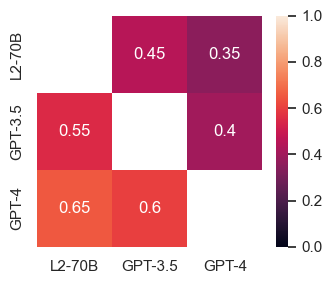

In [80]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(3.5, 3))
sns.heatmap(
    win_rates, 
    vmin=0.0, 
    vmax=1, 
    annot=True,
    ax=ax,
    # mask=arr_mask,
    xticklabels=["L2-70B", "GPT-3.5", "GPT-4"], 
    yticklabels=["L2-70B", "GPT-3.5", "GPT-4"],
)
plt.tight_layout()
plt.savefig("./assets/modeleval.pdf")
plt.show()